In [56]:
import cv2
import math
import os
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
from IPython.display import display
import PIL
from tensorflow.python.client import device_lib
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐
#그래프 세팅
font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }

#마이너스 폰트
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

#시각화?
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

#tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

#keras
import keras
from keras import models
from keras import layers
from keras import optimizers


print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4357229944191387275
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9093292767720076875
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2641330006562881942
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15416991176830857017
physical_device_desc: "device: XLA_GPU device"
]


In [60]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [85]:
base_dir = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\base_dir\\'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale =1./255)
batch_size = 20
print(train_dir)
print('train',len(os.listdir(train_dir)))
print('test',len(os.listdir(test_dir)))
print('val',len(os.listdir(validation_dir)))

C:\Users\yukir\Documents\Monicas_workspace\Deeplearning\Datasets\base_dir\train
train 5938
test 744
val 742


In [86]:
conv_base = ResNet50(weights ='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [87]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size = (150, 150),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    
    i=0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * batch_size : (i+1)*batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2969)
validation_features, validation_labels = extract_features(validation_dir,371)
test_features, test_labels = extract_features(test_dir, 372)

Found 0 images belonging to 0 classes.


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [ ]:
#완전분류기로 주입하기위해 펼치기
train_features = np.reshape(train_features, (2969, 5 * 5 * 2048))
test_features = np.reshape(test_features, (372, 5 * 5 * 2048))
validation_features = np.reshape(validation_features, (371, 5 * 5 * 2048))

In [63]:
#완전분류기 정의하기
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim =5*5*2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc',tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives')])
#self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])  

history = model.fit(train_features, train_labels,
                   epochs=5,
                   batch_size=20,
                   validation_data = (validation_features, validation_labels))

Epoch 1/5
149/149 [==============================] - 2s 13ms/step - loss: 0.0048 - acc: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 5.0000 - false_negatives: 0.0000e+00 - val_loss: 3.9657e-07 - val_acc: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00
Epoch 2/5
149/149 [==============================] - 2s 11ms/step - loss: 3.2448e-07 - acc: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - val_loss: 3.6490e-10 - val_acc: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_false_negatives: 0.0000e+00
Epoch 3/5
149/149 [==============================] - 2s 11ms/step - loss: 4.0038e-09 - acc: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - val_loss: 7.9792e-11 - val_acc: 1.0000 - val_precision: 0.0000e+00 - v

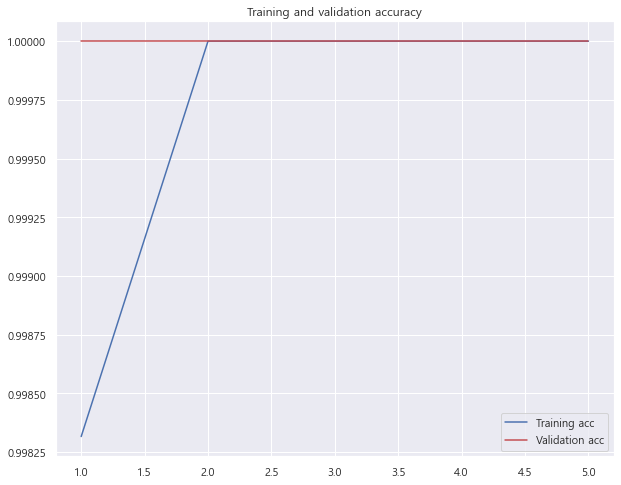

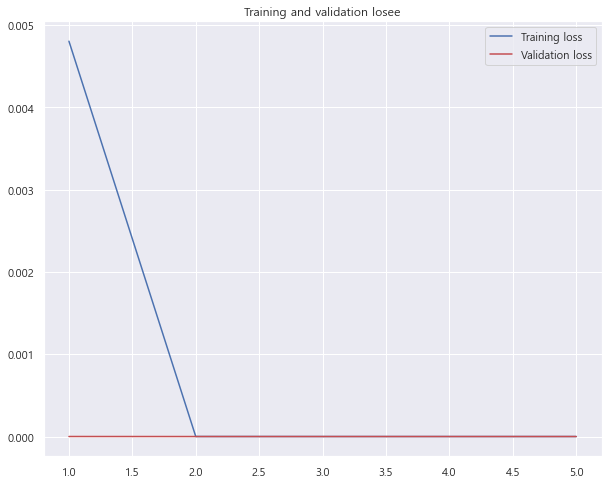

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation losee')
plt.legend()

plt.show()

In [72]:
model.evaluate(train_features, batch_size=batch_size)

149/149 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [83]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(train_features, batch_size=batch_size)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, \
        false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

149/149 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
loss: 0.000, accuracy: 0.000, precision: 0.000, recall: 0.000, false_positive: 0.000,         false_negative: 0.000, f1score: 0.000


In [79]:
def f1score(_recall, _precision):
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    # return a single tensor value
    return _f1score

In [80]:
f1score(_recall, _precision)

0.0